# Problem 2 CMA
Bhargav Chandaka and Luke LaLonde

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d
from numpy.random import multivariate_normal
import copy
from functools import partial

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context('talk')
    #sns.set(font_scale=1.4)
except ImportError:
    plt.style.use('seaborn-whitegrid')

In [117]:
class CMAES:
    
    def __init__(self, initial_mean, sigma, popsize, **kwargs):
        
        self.problem = None
        
        # Things that evolve : centroid, sigma, paths etc.
        self.centroid = np.asarray(initial_mean).copy()
        self.sigma = sigma
        self.pc = np.zeros_like(initial_mean)
        self.ps = np.zeros_like(initial_mean)        
        self.C = np.eye(initial_mean.shape[0])
        self.B = np.eye(self.C.shape[0])
        self.diagD = np.ones(initial_mean.shape[0])
        
        # Optimal popsize 
        self.popsize = popsize
        self.mu = popsize // 2
        
        # Update weights later on
        # Constant weight policy
        # self.weights = np.ones((self.mu, )) / self.mu

        # Decreasing weight policy
        self.weights = np.arange(self.mu, 0.0, -1.0)
        self.weights /= np.sum(self.weights)
        
        # Negative, Positive weight policy
        # unscaled_weights = np.arange(1.0 ,  1.0 + popsize)
        # unscaled_weights = np.log(0.5 * (popsize + 1.0) / unscaled_weights)

        # Utility variables
        self.dim = initial_mean.shape[0]

        # Expectation of a normal distribution
        self.chiN = np.sqrt(self.dim) * (1.0 - 0.25 / self.dim + 1.0/(21.0 * self.dim**2))
        self.mueff = 1.0 / np.linalg.norm(self.weights, 2)**2
        self.generations = 0
        
        # Options
 
        # Sigma adaptation
        # cs is short for c_sigma
        self.cs = kwargs.get("cs", (2.0 + self.mueff) / (self.dim + self.mueff + 5.0))
        # ds is short for d_sigma
        self.ds = 1.0 + 2.0 * max(0.0, np.sqrt((self.mueff - 1.0)/ (self.dim + 1.0)) - 1.0) + self.cs
        
        # Covariance adaptation
        self.cc = kwargs.get("cc", (4.0 + self.mueff/self.dim) / (self.dim + 4.0 + 2.0 * self.mueff/self.dim))
        self.ccov = 0.0
        # If implementing the latest version of CMA according to the tutorial, 
        # these parameters can be useful
        self.ccov1 = 2.0 / ((self.dim + 1.3)**2 + self.mueff)
        self.ccovmu = min(1.0 - self.ccov1, 2.0 * (self.mueff - 2.0 + 1.0/self.mueff)/((self.dim + 2.0)**2 + self.mueff))
        
          # asserts to guide you
#         assert self.dim == 2, "We are dealing with a two-dimensional problem only"
#         assert self.centroid.shape == (2,), "Centroid shape is incorrect, did you tranpose it by mistake?"
#         assert self.sigma > 0.0, "Sigma is not a non-zero positive number!"
#         assert self.pc.shape == (2, ), "pc shape is incorrect, did you tranpose it by mistake?"
#         assert self.ps.shape == (2, ), "ps shape is incorrect, did you tranpose it by mistake?"
#         assert self.C.shape == (2, 2), "C's shape is incorrect, remember C is a matrix!"     
#         assert type(self.popsize) == int, "Population size not an integer"
#         assert self.popsize > 0 , "Population size is negative!"
#         assert self.popsize > 2 , "Too little population size, make it >2"
        
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []
        self.stats_sigma = []
    
    def update(self, problem, population):
        
        # -- store current state of the algorithm
        self.stats_centroids.append(copy.deepcopy(self.centroid))
        self.stats_covs.append(copy.deepcopy(self.C))
        self.stats_sigma.append(copy.deepcopy(self.sigma))
        
        # sort offspring
        population = sorted(population, key = lambda ind: problem(ind), reverse = True)
        
        # -- store sorted offspring
        self.stats_offspring.append(copy.deepcopy(population))
        
        old_centroid = self.centroid
        # Note : the following does m <- <x>_w
        # Note : this is equivalent to doing m <- m + sigma * <z>_w
        # as x = m + sigma * z provided the weights sum to 1.0 which it
        # does
        self.centroid = np.dot(self.weights, population[0:self.mu])
        
        # -- store new centroid
        self.stats_new_centroids.append(copy.deepcopy(self.centroid))
        
        c_diff = self.centroid - old_centroid
        
        # Cumulation : update evolution path
        # Equivalent to in-class definition
        self.ps = (1 - self.cs) * self.ps \
             + np.sqrt(self.cs * (2 - self.cs) * self.mueff) / self.sigma \
             * np.dot(self.B, (1. / self.diagD) * np.dot(self.B.T, c_diff))
        
        # -- store new evol path
        self.stats_ps.append(copy.deepcopy(self.ps))
        
        hsig = float((np.linalg.norm(self.ps) / 
                np.sqrt(1. - (1. - self.cs)**(2. * (self.generations + 1.))) / self.chiN
                < (1.4 + 2. / (self.dim + 1.))))
        
        self.pc = (1 - self.cc) * self.pc + hsig \
                  * np.sqrt(self.cc * (2 - self.cc) * self.mueff) / self.sigma \
                  * c_diff
        
        # Update covariance matrix
        artmp = population[0:self.mu] - old_centroid
        self.C = (1 - self.ccov1 - self.ccovmu + (1 - hsig) \
                   * self.ccov1 * self.cc * (2 - self.cc)) * self.C \
                + self.ccov1 * np.outer(self.pc, self.pc) \
                + self.ccovmu * np.dot((self.weights * artmp.T), artmp) \
                / self.sigma**2
        
        # -- store new covs
        self.stats_new_covs.append(copy.deepcopy(self.C))
        
        self.sigma *= np.exp((np.linalg.norm(self.ps) / self.chiN - 1.) \
                                * self.cs / self.ds)
        
        self.diagD, self.B = np.linalg.eigh(self.C)
        indx = np.argsort(self.diagD)
        
        self.cond = self.diagD[indx[-1]]/self.diagD[indx[0]]
        
        self.diagD = self.diagD[indx]**0.5
        self.B = self.B[:, indx]
        self.BD = self.B * self.diagD
        
    def calc_weight(self, pop, item_weights):
        weights = pop @ item_weights
        return weights
    
    # eliminate members that don't meet weight constraint
    def weight_constraint(self, pop, capacity, item_weights):
        too_high_idx = pop > 1
        pop[too_high_idx] = 1
        idx = (self.calc_weight(pop, item_weights) <= capacity)
        return pop[idx]
    
    def plot_fitness(self):
        best_generational_fitness = self.problem(np.array(self.stats_offspring)[:,0])
        plt.plot(best_generational_fitness, label = "Best Fitness in Generation")
        overall_max_fitness = best_generational_fitness[0]
        best_overall_fitness = np.zeros(best_generational_fitness.size,)
        for i in np.arange(best_generational_fitness.size):
            if best_generational_fitness[i] > overall_max_fitness:
                overall_max_fitness = best_generational_fitness[i]
            best_overall_fitness[i] = overall_max_fitness
        plt.plot(best_overall_fitness, label = "Best Fitness Overall")
        
        average_fitness = np.zeros(best_generational_fitness.size,)
        for i in np.arange(best_generational_fitness.size):
            average_fitness[i] = np.mean(self.problem(np.array(self.stats_offspring[i])))
            
        plt.plot(average_fitness, label = "Average Fitness in Generation")
        plt.title('Fitness vs Generation')
        plt.xlabel('generations')
        plt.ylabel('fitness')
        plt.legend(prop={'size': 12})
        plt.show()
        
        print("Final best fitness: ", best_generational_fitness[-1])

        
    def plot_sigma(self):
        plt.plot(self.stats_sigma)
        plt.title('Sigma vs Generation')
        plt.xlabel('generations')
        plt.ylabel('variance')
        plt.show()
        
        print("Final sigma: ", self.stats_sigma[-1])

        
    def run(self, problem, data_set):
        self.problem = problem
        
        n_items = int(data_set['n_items'])
        bag_capacity = int(data_set['capacity'])
        item_values = data_set['item_values']
        item_weights = data_set['item_weights']
        
        # At the start, clear all stored cache and start a new campaign
        self.reset()
        
        while self.generations < 80:
            # Sample the population here!
            population = np.absolute(np.round(np.random.multivariate_normal(self.centroid, self.sigma**2 * self.C, self.popsize)))
            population = self.weight_constraint(population, bag_capacity, item_weights)
            while population[:,0].size < self.popsize:
                n = self.popsize-population[:,0].size
                new_members = np.absolute(np.round(multivariate_normal(self.centroid, self.sigma**2 * self.C, n)))
                population = np.vstack((population,new_members))
                population = self.weight_constraint(population, bag_capacity, item_weights)

            # Pass the population to update, which computes all new parameters 
            self.update(problem, population)
            # print(np.array(population).shape)
            self.generations += 1

        return population
        
    def reset(self):
        # Clears everything to rerun the problem
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []

In [118]:
def knapsack_value(item_vals,population):
    return population @ item_vals

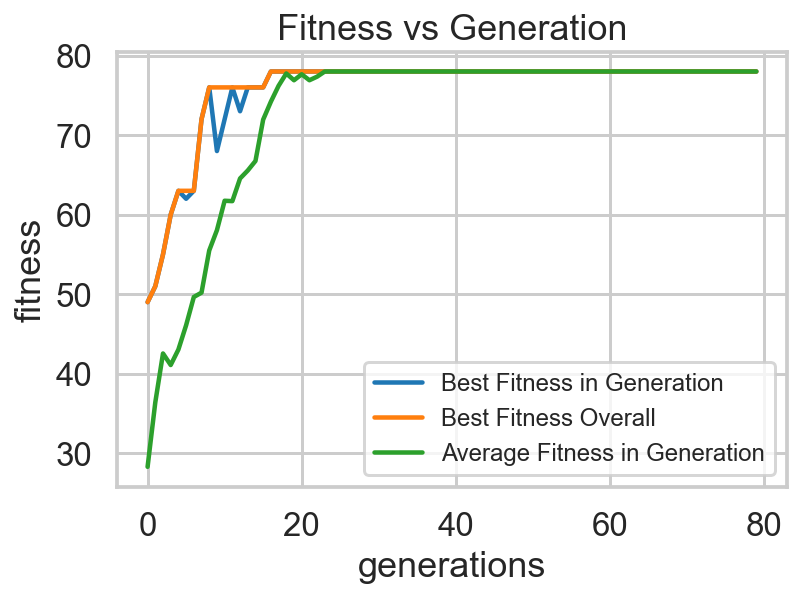

Final best fitness:  78.0


In [119]:
# dataset A: algorithm to find optimal solution -- high initial sigma
n_items = int(np.load('A.npz')['n_items'])

initial_centroid_A = np.zeros(n_items,) 
knapsack_A = partial(knapsack_value, np.load('A.npz')['item_values'])

cma_es = CMAES(initial_centroid_A, 0.45, 20)
final_pop = cma_es.run(knapsack_A, np.load('A.npz'))
cma_es.plot_fitness()

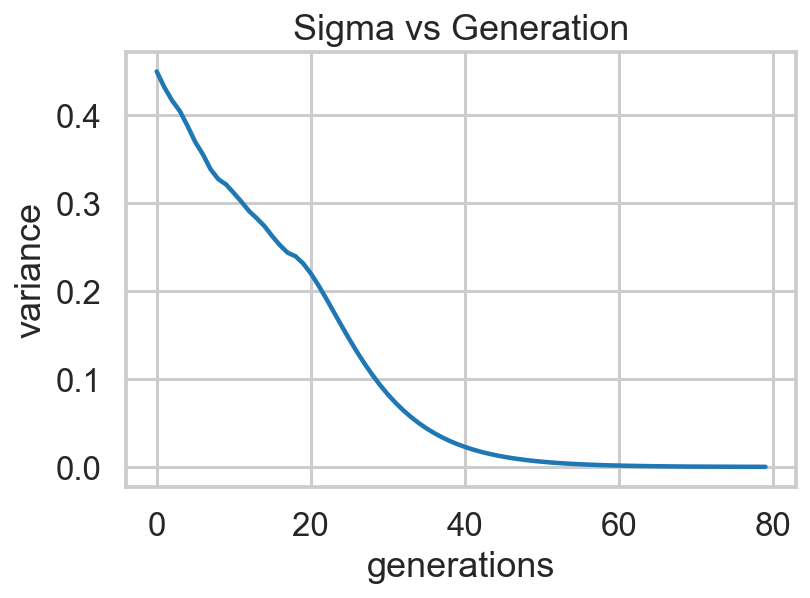

Final sigma:  0.0001168362160368468


In [120]:
cma_es.plot_sigma()

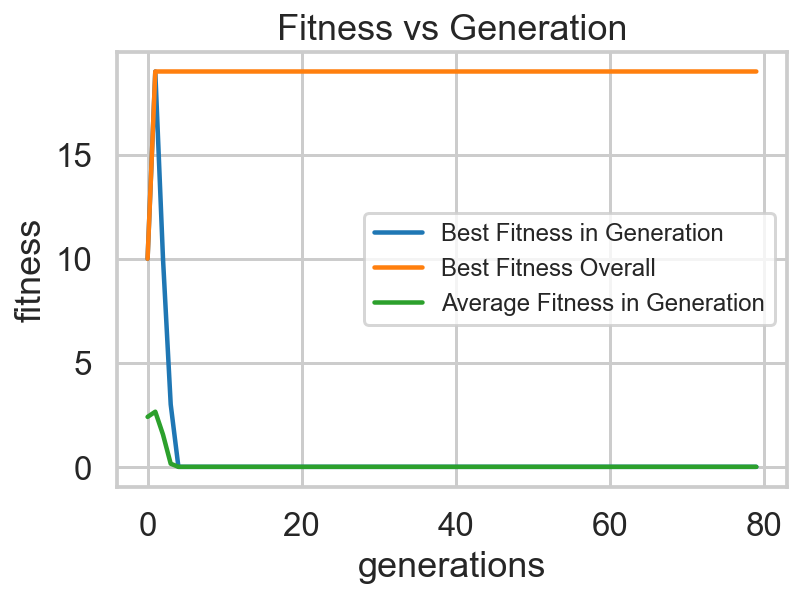

Final best fitness:  0.0


In [121]:
# dataset A: algorithm to find optimal solution -- low initial sigma --> volatile
n_items = int(np.load('A.npz')['n_items'])

initial_centroid_A = np.zeros(n_items,) 
knapsack_A = partial(knapsack_value, np.load('A.npz')['item_values'])

cma_es = CMAES(initial_centroid_A, 0.2, 20)
final_pop = cma_es.run(knapsack_A, np.load('A.npz'))
cma_es.plot_fitness()

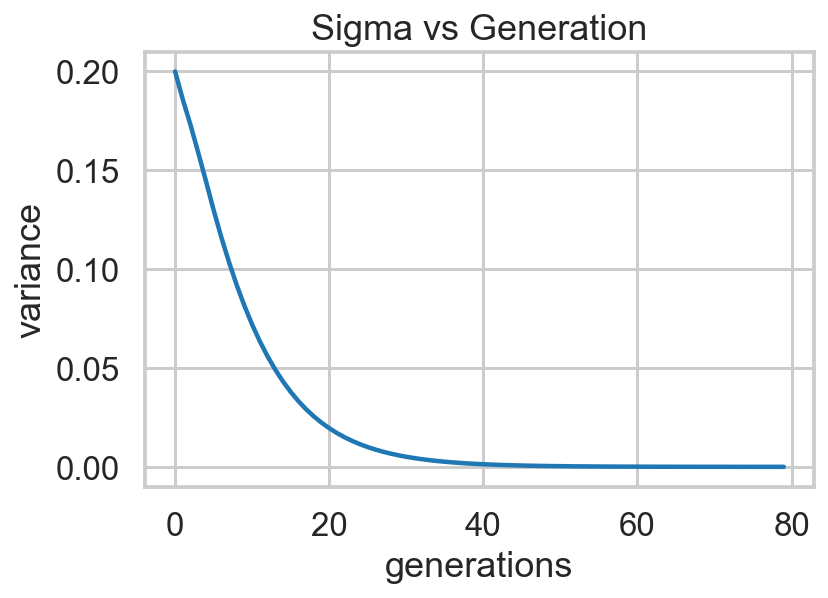

Final sigma:  6.653215276923275e-06


In [122]:
cma_es.plot_sigma()

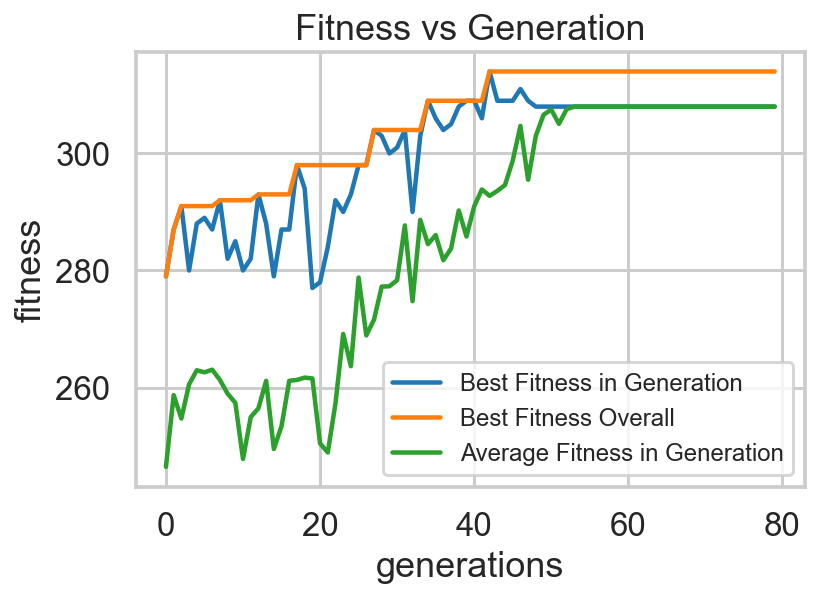

Final best fitness:  308.0


In [123]:
# dataset B: algorithm to find optimal solution -- large initial sigma
n_items = int(np.load('B.npz')['n_items'])

initial_centroid_B = np.zeros(n_items,) 
knapsack_B = partial(knapsack_value, np.load('B.npz')['item_values'])

cma_es = CMAES(initial_centroid_B, 0.7, 20)
final_pop = cma_es.run(knapsack_B, np.load('B.npz'))

cma_es.plot_fitness()

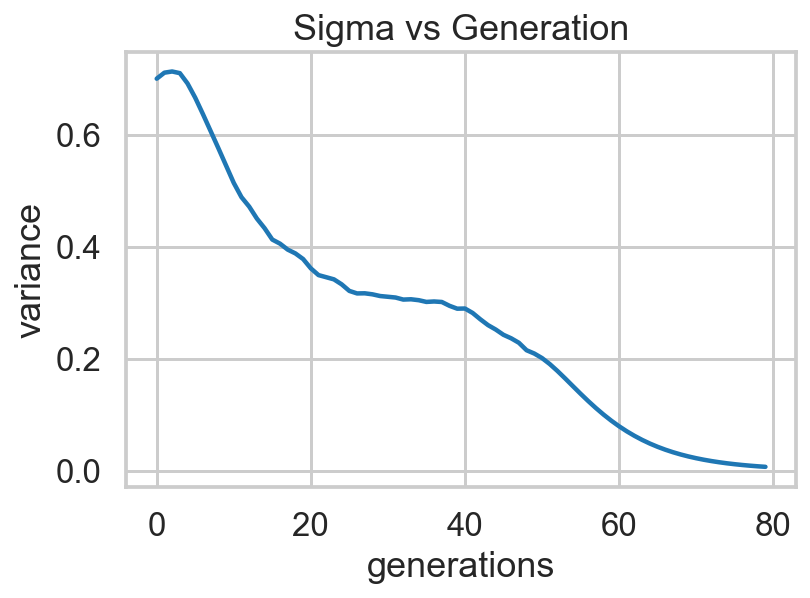

Final sigma:  0.006588059234573081


In [124]:
cma_es.plot_sigma()

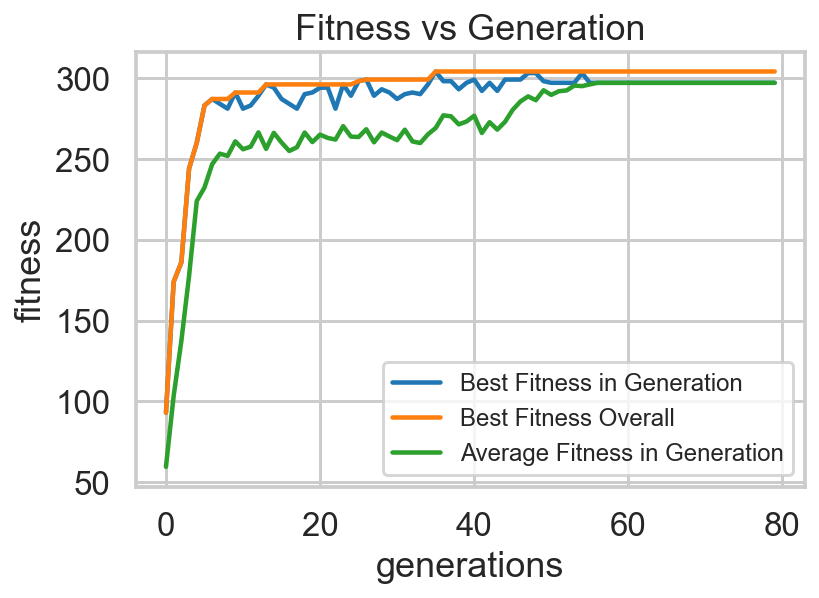

Final best fitness:  297.0


In [125]:
# dataset B: algorithm to find optimal solution -- small initial sigma
n_items = int(np.load('B.npz')['n_items'])

initial_centroid_B = np.zeros(n_items,) 
knapsack_B = partial(knapsack_value, np.load('B.npz')['item_values'])

cma_es = CMAES(initial_centroid_B, 0.3, 20)
final_pop = cma_es.run(knapsack_B, np.load('B.npz'))

cma_es.plot_fitness()

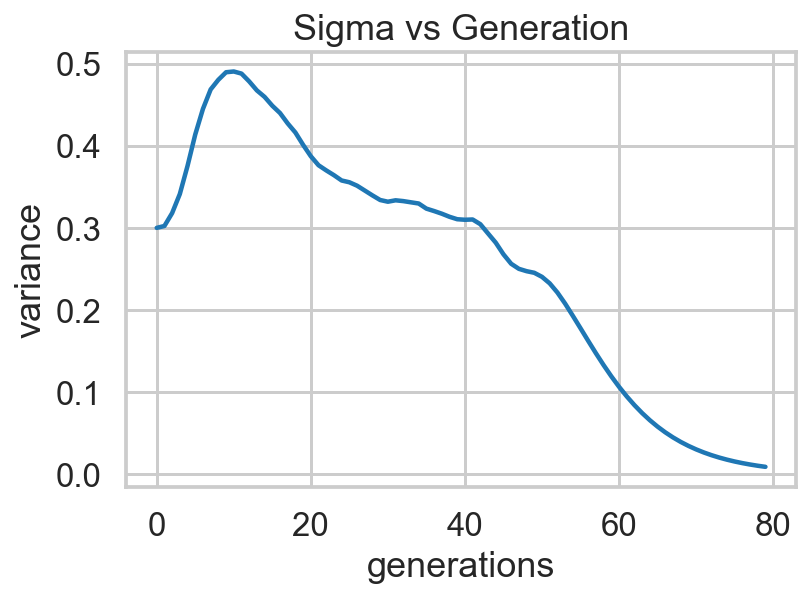

Final sigma:  0.009130805931862074


In [126]:
cma_es.plot_sigma()